# Model Comparison: Llama vs InternVL3

**Business Document Processing Performance Analysis**

---

This notebook provides a comprehensive side-by-side comparison of Llama-3.2-Vision-11B and InternVL3-8B models for business document information extraction.

## Key Business Questions Addressed:
1. **Accuracy**: Which model extracts information more reliably?
2. **Speed**: Which model processes documents faster?
3. **Document Type Performance**: How do models perform on invoices, receipts, and bank statements?
4. **Resource Efficiency**: Which model provides better ROI?
5. **Production Readiness**: Which model is recommended for deployment?

## 1. Setup and Configuration

In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from rich import print as rprint
from rich.console import Console

warnings.filterwarnings('ignore')
console = Console()

# Set professional styling for executive presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration with flexible path handling - consistent with batch notebooks
# Define base path for flexible deployment

base_data_path = '/home/jovyan/nfs_share/tod/LMM_POC'
# base_data_path = '/home/jovyan/LMM_POC-oct6'
# base_data_path = '/Users/tod/Desktop/LMM_POC'

CONFIG = {
    # Path settings - Now supports both absolute and relative paths
    'output_dir': f'{base_data_path}/output/csv',  # Can be relative or absolute path
    'ground_truth_path': f'{base_data_path}/evaluation_data/ground_truth.csv',  # Ground truth for field accuracy
    
    # UPDATED: File patterns matching new notebook naming conventions
    # Current naming: llama_batch_results_*.csv, internvl3_batch_results_*.csv, etc.
    'llama_pattern': 'llama_batch_results_*.csv',
    'internvl3_quantized_pattern': 'internvl3_batch_results_*.csv',  # Matches quantized InternVL3 (2B or 8B)
    'internvl3_non_quantized_pattern': 'internvl3_non_quantized_batch_results_*.csv',  # Matches non-quantized
    
    # Visualization settings
    'figure_size': (16, 10),
    'dpi': 300,
    'save_format': 'png'
}

# Examples of flexible path configuration:
# Relative paths (relative to current working directory):
#   'output_dir': 'output/csv'
#
# Absolute paths (can be anywhere on the system):
#   'output_dir': '/home/user/results/vision_model_outputs/csv'
#
# Environment variable based paths:
#   'output_dir': os.path.join(os.getenv('OUTPUT_DIR', 'output'), 'csv')
#
# Dynamic paths based on other locations:
#   base_results_path = '/mnt/shared_data/vision_results'
#   'output_dir': f'{base_results_path}/csv'

print("✅ Model comparison configuration loaded")
print(f"📁 Output directory: {CONFIG['output_dir']}")
print(f"🔍 Looking for CSV files in: {Path(CONFIG['output_dir']).absolute()}")

✅ Model comparison configuration loaded
📁 Output directory: /home/jovyan/nfs_share/tod/LMM_POC/output/csv
🔍 Looking for CSV files in: /home/jovyan/nfs_share/tod/LMM_POC/output/csv


## 2. Data Loading and Preparation

In [2]:
def load_latest_results(output_dir: str, pattern: str, model_name: str) -> pd.DataFrame:
    """
    Load the most recent CSV results file matching the given pattern.
    
    Args:
        output_dir: Directory to search for files (supports absolute and relative paths)
        pattern: Glob pattern to match files
        model_name: Name of the model for the 'model' column
        
    Returns:
        DataFrame with results, or empty DataFrame if no files found
    """
    import glob
    from pathlib import Path
    
    # Handle both absolute and relative paths
    output_path = Path(output_dir)
    if not output_path.is_absolute():
        # If relative, make it relative to current working directory
        output_path = Path.cwd() / output_path
    
    search_path = output_path / pattern
    files = glob.glob(str(search_path))
    
    if not files:
        rprint(f"[yellow]⚠️ No files found matching pattern: {pattern}[/yellow]")
        rprint(f"[dim]   Searched in: {output_path}[/dim]")
        return pd.DataFrame()
    
    # Get the most recent file
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    rprint(f"[green]✅ Loading {model_name} data from: {Path(latest_file).name}[/green]")
    
    try:
        df = pd.read_csv(latest_file)
        
        # Add model column if it doesn't exist
        if 'model' not in df.columns:
            df['model'] = model_name
        
        # Ensure required columns exist
        required_cols = ['overall_accuracy', 'processing_time', 'document_type']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            rprint(f"[yellow]⚠️ Missing columns in {model_name} data: {missing_cols}[/yellow]")
            # Create dummy columns with default values
            for col in missing_cols:
                if col == 'overall_accuracy':
                    df[col] = 0.0
                elif col == 'processing_time':
                    df[col] = 1.0
                elif col == 'document_type':
                    df[col] = 'unknown'
        
        return df
        
    except Exception as e:
        rprint(f"[red]❌ Error loading {model_name} data from {latest_file}: {e}[/red]")
        return pd.DataFrame()

In [3]:
# Load data for all available models
rprint("[bold blue]📊 Loading Model Performance Data[/bold blue]")

llama_df = load_latest_results(CONFIG['output_dir'], CONFIG['llama_pattern'], 'Llama-3.2-Vision')
internvl3_quantized_df = load_latest_results(CONFIG['output_dir'], CONFIG['internvl3_quantized_pattern'], 'InternVL3-Quantized-8B')
internvl3_non_quantized_df = load_latest_results(CONFIG['output_dir'], CONFIG['internvl3_non_quantized_pattern'], 'InternVL3-NonQuantized-2B')

# Combine all available dataframes
dfs_to_concat = []
if not llama_df.empty:
    dfs_to_concat.append(llama_df)
if not internvl3_quantized_df.empty:
    dfs_to_concat.append(internvl3_quantized_df)
if not internvl3_non_quantized_df.empty:
    dfs_to_concat.append(internvl3_non_quantized_df)

if dfs_to_concat:
    combined_df = pd.concat(dfs_to_concat, ignore_index=True)
    rprint(f"[green]✅ Combined dataset: {len(combined_df)} records from {len(dfs_to_concat)} models[/green]")
    
    # Show what models were loaded
    loaded_models = combined_df['model'].unique()
    rprint(f"[cyan]📋 Models loaded: {', '.join(loaded_models)}[/cyan]")
else:
    rprint("[red]❌ No data loaded for any model[/red]")
    rprint("\n[yellow]💡 To use this notebook:[/yellow]")
    rprint("  1. Run llama_batch.ipynb to generate Llama results")
    rprint("  2. Run ivl3_batch.ipynb to generate InternVL3 quantized results")
    rprint("  3. Run ivl3_8b_batch_non_quantized.ipynb for non-quantized results")
    rprint("  4. Re-run this notebook to generate the comparison")
    combined_df = pd.DataFrame()

📊 Loading Model Performance Data

✅ Loading Llama-3.2-Vision data from: llama_batch_results_20251019_013131.csv

✅ Loading InternVL3-Quantized-8B data from: internvl3_batch_results_20251016_062451.csv

✅ Loading InternVL3-NonQuantized-2B data from: internvl3_non_quantized_batch_results_20251019_013743.csv

✅ Combined dataset: 27 records from 3 models

📋 Models loaded: Llama-3.2-Vision, InternVL3-Quantized-8B, InternVL3-NonQuantized-2B

In [4]:
def generate_executive_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate executive summary statistics from combined model data.
    
    Args:
        df: Combined DataFrame with all model results
        
    Returns:
        DataFrame with summary statistics per model
    """
    if df.empty:
        return pd.DataFrame()
    
    summary_stats = df.groupby('model').agg({
        'overall_accuracy': ['mean', 'std', 'min', 'max'],
        'processing_time': ['mean', 'std', 'min', 'max'],
        'fields_extracted': 'mean',
        'fields_matched': 'mean'
    }).round(2)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
    
    # Calculate throughput (documents per minute)
    summary_stats['throughput_docs_per_min'] = (60 / summary_stats['processing_time_mean']).round(2)
    
    # Calculate efficiency score (accuracy × throughput)
    summary_stats['efficiency_score'] = (summary_stats['overall_accuracy_mean'] * summary_stats['throughput_docs_per_min']).round(2)
    
    return summary_stats.reset_index()

📊 Creating Executive Dashboard

✅ Executive dashboard saved to: output/visualizations/executive_comparison_20251019_023600.png

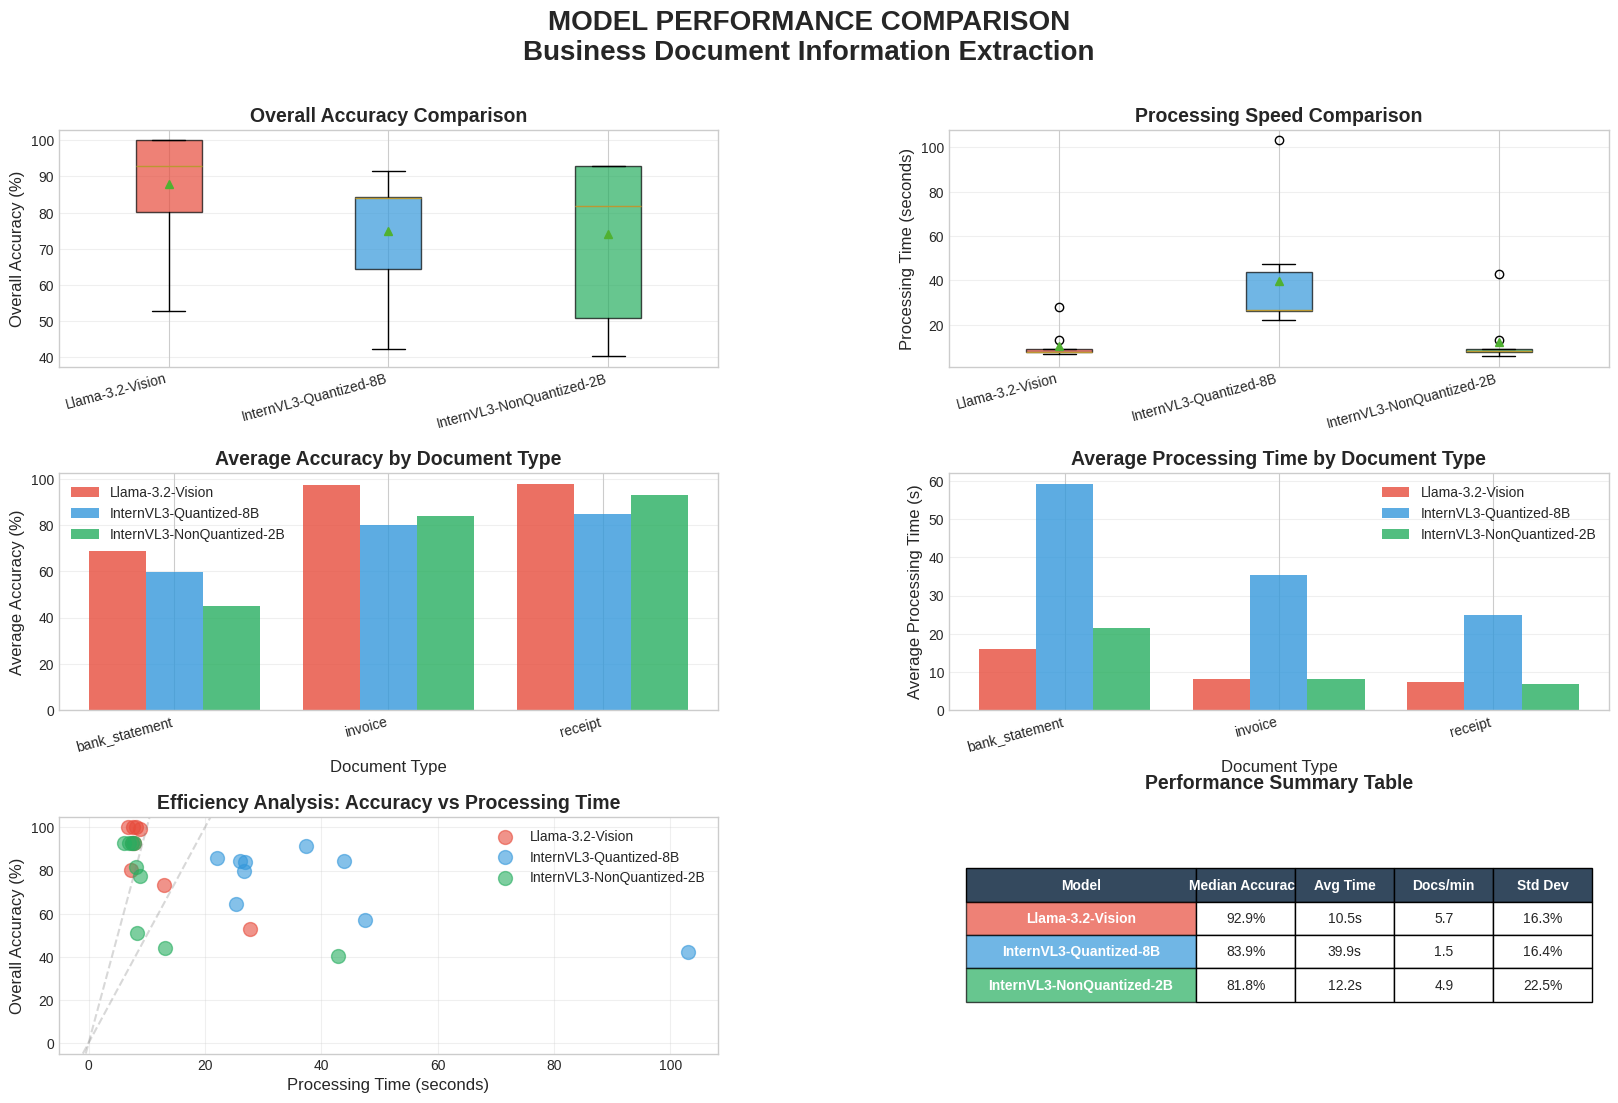

✅ Executive dashboard created successfully

In [5]:
def create_executive_dashboard(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive 6-panel executive dashboard comparing model performance.
    
    Args:
        df: Combined DataFrame with results from all models
        save_path: Optional path to save the visualization
    """
    if df.empty:
        rprint("[red]❌ Cannot create dashboard - no data available[/red]")
        return
    
    # Define model order and colors for consistency
    model_order = ['Llama-3.2-Vision', 'InternVL3-Quantized-8B', 'InternVL3-NonQuantized-2B']
    fixed_colors = {
        'Llama-3.2-Vision': '#E74C3C',
        'InternVL3-Quantized-8B': '#3498DB', 
        'InternVL3-NonQuantized-2B': '#27AE60'
    }
    
    # Filter to only available models and maintain order
    available_models = df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = [fixed_colors[model] for model in models if model in fixed_colors]
    
    # Create figure with 6 subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.45, wspace=0.35)
    
    # 1. Overall Accuracy Comparison (Box Plot)
    ax1 = fig.add_subplot(gs[0, 0])
    df_plot = df[df['model'].isin(models)]
    
    box_parts = ax1.boxplot(
        [df_plot[df_plot['model'] == model]['overall_accuracy'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax1.set_title('Overall Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticklabels(models, rotation=15, ha='right')
    
    # 2. Processing Speed Comparison (Box Plot)
    ax2 = fig.add_subplot(gs[0, 1])
    
    box_parts = ax2.boxplot(
        [df_plot[df_plot['model'] == model]['processing_time'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Processing Time (seconds)', fontsize=12)
    ax2.set_title('Processing Speed Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticklabels(models, rotation=15, ha='right')
    
    # 3. Average Accuracy by Document Type (Grouped Bar Chart)
    ax3 = fig.add_subplot(gs[1, 0])
    
    doc_accuracy = df_plot.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    doc_accuracy = doc_accuracy[models]  # Ensure correct order
    
    x = np.arange(len(doc_accuracy.index))
    width = 0.8 / len(models)
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax3.bar(x + offset, doc_accuracy[model], width, 
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax3.set_ylabel('Average Accuracy (%)', fontsize=12)
    ax3.set_xlabel('Document Type', fontsize=12)
    ax3.set_title('Average Accuracy by Document Type', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(doc_accuracy.index, rotation=15, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Average Processing Time by Document Type (Grouped Bar Chart)
    ax4 = fig.add_subplot(gs[1, 1])
    
    doc_time = df_plot.groupby(['document_type', 'model'])['processing_time'].mean().unstack()
    doc_time = doc_time[models]  # Ensure correct order
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax4.bar(x + offset, doc_time[model], width,
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax4.set_ylabel('Average Processing Time (s)', fontsize=12)
    ax4.set_xlabel('Document Type', fontsize=12)
    ax4.set_title('Average Processing Time by Document Type', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(doc_time.index, rotation=15, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Efficiency Analysis: Accuracy vs Processing Time (Scatter Plot)
    ax5 = fig.add_subplot(gs[2, 0])
    
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        ax5.scatter(model_data['processing_time'], model_data['overall_accuracy'],
                   label=model, color=fixed_colors[model], alpha=0.6, s=100)
    
    ax5.set_xlabel('Processing Time (seconds)', fontsize=12)
    ax5.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax5.set_title('Efficiency Analysis: Accuracy vs Processing Time', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Add diagonal efficiency lines
    ax5.axline((0, 0), slope=10, color='gray', linestyle='--', alpha=0.3, label='10% per second')
    ax5.axline((0, 0), slope=5, color='gray', linestyle='--', alpha=0.3, label='5% per second')
    
    # 6. Performance Summary Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Generate summary statistics
    summary_data = []
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        summary_data.append([
            model,
            f"{model_data['overall_accuracy'].median():.1f}%",
            f"{model_data['processing_time'].mean():.1f}s",
            f"{(60 / model_data['processing_time'].mean()):.1f}",
            f"{model_data['overall_accuracy'].std():.1f}%"
        ])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Model', 'Median Accuracy', 'Avg Time', 'Docs/min', 'Std Dev'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color header row
    for i in range(5):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows with model colors
    for i, model in enumerate(models):
        if model in fixed_colors:
            table[(i+1, 0)].set_facecolor(fixed_colors[model])
            table[(i+1, 0)].set_text_props(color='white', weight='bold')
            table[(i+1, 0)].set_alpha(0.7)
    
    ax6.set_title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
    
    # Overall title
    fig.suptitle('MODEL PERFORMANCE COMPARISON\nBusiness Document Information Extraction',
                fontsize=20, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight')
        rprint(f"[green]✅ Executive dashboard saved to: {save_path}[/green]")
    
    plt.show()

# Create the executive dashboard
dashboard_timestamp = None
if not combined_df.empty:
    rprint("\n[bold blue]📊 Creating Executive Dashboard[/bold blue]")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"output/visualizations/executive_comparison_{timestamp}.png")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_executive_dashboard(combined_df, str(output_path))
    dashboard_timestamp = timestamp
    
    rprint(f"[green]✅ Executive dashboard created successfully[/green]")
else:
    rprint("[red]❌ Cannot create executive dashboard - no data available[/red]")

In [6]:
def extract_field_level_accuracy_from_csv(output_dir: str, pattern: str, model_name: str, ground_truth_path: str) -> pd.DataFrame:
    """
    Extract field-level accuracy by comparing CSV batch results against ground truth.
    
    This function:
    1. Loads batch results CSV (which has extracted field values)
    2. Loads ground truth CSV
    3. Compares field-by-field using the SAME evaluation logic as llama_batch.ipynb
    4. Returns per-field accuracy WITHOUT re-running document-type filtering
    
    Args:
        output_dir: Directory containing batch results CSV files
        pattern: Glob pattern to match files  
        model_name: Name of the model
        ground_truth_path: Path to ground truth CSV
        
    Returns:
        DataFrame with columns: model, field_name, accuracy, correct_count, total_count
    """
    import glob
    from pathlib import Path
    import sys
    sys.path.insert(0, str(Path.cwd()))
    
    from common.evaluation_metrics import load_ground_truth, calculate_field_accuracy
    
    output_path = Path(output_dir)
    if not output_path.is_absolute():
        output_path = Path.cwd() / output_path
    
    search_path = output_path / pattern  
    files = glob.glob(str(search_path))
    
    if not files:
        rprint(f"[yellow]⚠️ No batch results found: {pattern}[/yellow]")
        rprint(f"[dim]   Searched in: {output_path}[/dim]")
        return pd.DataFrame()
    
    # Get the most recent file
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    rprint(f"[cyan]📄 Evaluating {model_name} from: {Path(latest_file).name}[/cyan]")
    
    try:
        # Load batch results CSV
        batch_df = pd.read_csv(latest_file)
        total_images = len(batch_df)
        rprint(f"[dim]  DEBUG: Loaded {total_images} rows from batch CSV[/dim]")
        
        # Load ground truth
        gt_path = Path(ground_truth_path)
        if not gt_path.exists():
            rprint(f"[red]  ❌ Ground truth not found: {ground_truth_path}[/red]")
            return pd.DataFrame()
            
        ground_truth_map = load_ground_truth(str(gt_path), show_sample=False, verbose=False)
        rprint(f"[dim]  DEBUG: Ground truth has {len(ground_truth_map)} entries[/dim]")
        
        # Determine which column to use for matching
        # Ground truth uses image_file, batch CSV has both image_file and image_name
        image_col = 'image_file' if 'image_file' in batch_df.columns else 'image_name'
        
        # DEBUG: Show sample image names
        if len(batch_df) > 0:
            sample_batch_names = batch_df[image_col].head(3).tolist()
            rprint(f"[dim]  DEBUG: Sample batch image names (from {image_col}): {sample_batch_names}[/dim]")
        
        if len(ground_truth_map) > 0:
            sample_gt_names = list(ground_truth_map.keys())[:3]
            rprint(f"[dim]  DEBUG: Sample ground truth names: {sample_gt_names}[/dim]")
        
        # FILTER: Only evaluate images that have ground truth
        # FIX: Match using image_file column (consistent with ground truth)
        batch_df_filtered = batch_df[batch_df[image_col].isin(ground_truth_map.keys())]
        filtered_count = len(batch_df_filtered)
        skipped_count = total_images - filtered_count
        
        rprint(f"[dim]  DEBUG: Filtered to {filtered_count} matching images (skipped {skipped_count})[/dim]")
        
        if filtered_count == 0:
            rprint(f"[red]  ❌ No images in batch match ground truth entries[/red]")
            return pd.DataFrame()
        
        rprint(f"[cyan]  📊 Evaluating {filtered_count}/{total_images} images with ground truth[/cyan]")
        
        # Track field accuracies - accumulate across all images
        field_accuracies = {}
        
        # Get all possible field columns (exclude metadata columns)
        metadata_cols = {'image_file', 'image_name', 'document_type', 'processing_time', 
                         'field_count', 'found_fields', 'field_coverage', 'prompt_used', 
                         'timestamp', 'overall_accuracy', 'fields_extracted', 'fields_matched', 
                         'total_fields', 'inference_only', 'model', 'image_stem'}
        
        field_columns = [col for col in batch_df_filtered.columns if col not in metadata_cols]
        
        rprint(f"[dim]  DEBUG: Found {len(field_columns)} field columns to evaluate[/dim]")
        
        # Evaluate each image
        for _, row in batch_df_filtered.iterrows():
            image_identifier = row[image_col]
            
            # Get ground truth for this image (use image_identifier as key)
            gt_data = ground_truth_map.get(image_identifier)
            if not gt_data:
                continue
            
            # Compare each field
            for field_name in field_columns:
                extracted_value = row.get(field_name, 'NOT_FOUND')
                ground_truth_value = gt_data.get(field_name, 'NOT_FOUND')
                
                # Skip if both are NOT_FOUND (field not applicable)
                if str(extracted_value).upper() == 'NOT_FOUND' and str(ground_truth_value).upper() == 'NOT_FOUND':
                    continue
                
                # Calculate accuracy score using the same logic as batch notebooks
                accuracy_score = calculate_field_accuracy(
                    extracted_value, ground_truth_value, field_name, debug=False
                )
                
                # Initialize field tracking if needed
                if field_name not in field_accuracies:
                    field_accuracies[field_name] = {'correct': 0.0, 'total': 0}
                
                field_accuracies[field_name]['total'] += 1
                field_accuracies[field_name]['correct'] += accuracy_score
        
        rprint(f"[dim]  DEBUG: Computed accuracies for {len(field_accuracies)} fields[/dim]")
        
        if not field_accuracies:
            rprint(f"[yellow]  ⚠️ No field accuracies computed[/yellow]")
            return pd.DataFrame()
        
        # Convert to DataFrame
        field_data = []
        for field_name, data in field_accuracies.items():
            accuracy = data['correct'] / data['total'] if data['total'] > 0 else 0.0
            field_data.append({
                'model': model_name,
                'field_name': field_name,
                'accuracy': accuracy,
                'correct_count': data['correct'],
                'total_count': data['total']
            })
        
        # Calculate average accuracy
        avg_accuracy = sum(d['accuracy'] for d in field_data) / len(field_data) if field_data else 0.0
        
        rprint(f"[green]  ✅ Computed accuracy for {len(field_data)} fields (avg: {avg_accuracy:.1%})[/green]")
        return pd.DataFrame(field_data)
        
    except Exception as e:
        rprint(f"[red]❌ Error evaluating {model_name}: {e}[/red]")
        import traceback
        rprint(f"[dim]{traceback.format_exc()}[/dim]")
        return pd.DataFrame()

# Load field-level accuracy data from CSV files (NOT re-running evaluation)
rprint("\n[bold blue]📊 Computing Field-Level Accuracy (from CSV + Ground Truth)[/bold blue]")
rprint("[dim]Comparing batch CSV results against ground truth for field-level metrics[/dim]\n")

# Determine ground truth path - FAIL FAST if not found
gt_path = CONFIG['ground_truth_path']

rprint(f"[cyan]Expected ground truth path: {gt_path}[/cyan]")
rprint(f"[dim]  Absolute path: {Path(gt_path).absolute()}[/dim]")

if not Path(gt_path).exists():
    rprint(f"[bold red]❌ FATAL: Ground truth file not found![/bold red]")
    rprint(f"[yellow]💡 Expected location: {Path(gt_path).absolute()}[/yellow]")
    rprint(f"[yellow]💡 Check CONFIG['output_dir'] setting[/yellow]")
    rprint(f"[yellow]💡 Current CONFIG['output_dir']: {CONFIG.get('output_dir', 'NOT SET')}[/yellow]")
    raise FileNotFoundError(f"Ground truth not found: {gt_path}")

rprint(f"[green]✅ Ground truth file exists[/green]")



field_data_frames = []

if not llama_df.empty:
    llama_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['llama_pattern'], 'Llama-3.2-Vision', gt_path
    )
    if not llama_fields.empty:
        field_data_frames.append(llama_fields)
        
if not internvl3_quantized_df.empty:
    internvl3_q_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['internvl3_quantized_pattern'], 'InternVL3-Quantized-8B', gt_path
    )
    if not internvl3_q_fields.empty:
        field_data_frames.append(internvl3_q_fields)
        
if not internvl3_non_quantized_df.empty:
    internvl3_nq_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['internvl3_non_quantized_pattern'], 'InternVL3-NonQuantized-2B', gt_path
    )
    if not internvl3_nq_fields.empty:
        field_data_frames.append(internvl3_nq_fields)

if field_data_frames:
    field_level_df = pd.concat(field_data_frames, ignore_index=True)
    rprint(f"\n[green]✅ Field-level accuracy computed: {len(field_level_df)} field measurements[/green]")
    rprint(f"[cyan]📋 Unique fields: {field_level_df['field_name'].nunique()}[/cyan]")
    rprint(f"[cyan]📊 Models analyzed: {field_level_df['model'].nunique()}[/cyan]")
else:
    rprint("\n[red]❌ No field-level accuracy data available[/red]")
    rprint("[yellow]💡 This requires batch results CSVs and ground truth for evaluation[/yellow]")
    field_level_df = pd.DataFrame()

📊 Computing Field-Level Accuracy (from CSV + Ground Truth)

Comparing batch CSV results against ground truth for field-level metrics

Expected ground truth path: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

  Absolute path: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

✅ Ground truth file exists

📄 Evaluating Llama-3.2-Vision from: llama_batch_results_20251019_013131.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 19 field columns to evaluate

  DEBUG: Computed accuracies for 18 fields

  ✅ Computed accuracy for 18 fields (avg: 90.8%)

📄 Evaluating InternVL3-Quantized-8B from: internvl3_batch_results_20251016_062451.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 19 field columns to evaluate

  DEBUG: Computed accuracies for 18 fields

  ✅ Computed accuracy for 18 fields (avg: 72.6%)

📄 Evaluating InternVL3-NonQuantized-2B from: internvl3_non_quantized_batch_results_20251019_013743.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 20 field columns to evaluate

  DEBUG: Computed accuracies for 19 fields

  ✅ Computed accuracy for 19 fields (avg: 78.8%)

✅ Field-level accuracy computed: 55 field measurements

📋 Unique fields: 19

📊 Models analyzed: 3

## 3. Summary Statistics

In [7]:
def analyze_field_performance(field_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze and compare field-level performance across models.
    
    Args:
        field_df: DataFrame with field-level accuracy data
        
    Returns:
        DataFrame with field performance comparison
    """
    if field_df.empty:
        return pd.DataFrame()
    
    # Filter out metadata/internal fields that aren't business document fields
    exclude_fields = ['quantization_used', 'model', 'timestamp', 'processing_time', 'image_name', 'image_stem', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
    field_df = field_df[~field_df['field_name'].isin(exclude_fields)]
    
    if field_df.empty:
        return pd.DataFrame()
    
    # Pivot to get fields as rows, models as columns (using accuracy now)
    field_comparison = field_df.pivot_table(
        index='field_name',
        columns='model',
        values='accuracy',
        aggfunc='mean'
    )
    
    # Calculate average accuracy across all models
    field_comparison['avg_accuracy'] = field_comparison.mean(axis=1)
    
    # Calculate variance to identify fields with inconsistent performance
    field_comparison['variance'] = field_comparison.std(axis=1)
    
    # Identify best model for each field
    model_cols = [col for col in field_comparison.columns if col not in ['avg_accuracy', 'variance']]
    field_comparison['best_model'] = field_comparison[model_cols].idxmax(axis=1)
    field_comparison['best_score'] = field_comparison[model_cols].max(axis=1)
    
    # Sort by average accuracy
    field_comparison = field_comparison.sort_values('avg_accuracy', ascending=False)
    
    return field_comparison

# Analyze field performance if data is available
if not field_level_df.empty:
    field_performance = analyze_field_performance(field_level_df)
    
    rprint("\n[bold green]📊 FIELD-LEVEL ACCURACY ANALYSIS[/bold green]")
    
    # Show top performing fields with color gradient
    rprint("[bold blue]📊 All Fields Ranked by Accuracy:[/bold blue]")
    
    # Get model columns for styling
    model_cols = [col for col in field_performance.columns if col not in ["avg_accuracy", "variance", "best_model", "best_score"]]
    
    # Apply color gradient styling to all fields (already sorted by avg_accuracy descending)
    styled_all = field_performance.style.background_gradient(
        cmap="RdYlGn",
        subset=model_cols + ["avg_accuracy"],
        vmin=0,
        vmax=1
    ).format(
        {col: "{:.1%}" for col in field_performance.columns if col not in ["best_model", "variance", "best_score"]}
    ).format(
        {"variance": "{:.3f}"}
    )
    
    display(styled_all)
    
    # Save all fields table as PNG
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_table_dir = Path(f"{base_data_path}/output/tables")
    output_table_dir.mkdir(parents=True, exist_ok=True)
    all_fields_png_path = output_table_dir / f"field_accuracy_ranked_{timestamp}.png"
    
    # Render table as image using matplotlib
    fig, ax = plt.subplots(figsize=(16, 10))  # Taller for 17 fields
    ax.axis("tight")
    ax.axis("off")
    
    table_data = field_performance.values
    col_labels = list(field_performance.columns)
    row_labels = list(field_performance.index)
    
    table = ax.table(cellText=table_data, colLabels=col_labels, rowLabels=row_labels,
                     cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.8)
    
    plt.savefig(str(all_fields_png_path), dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()
    rprint(f"[green]✅ All fields table saved: {all_fields_png_path}[/green]")
    
    # Field performance summary
    rprint(f"[cyan]📈 Total evaluation fields: {len(field_performance)}[/cyan]")
    rprint(f"[cyan]📊 Average accuracy range: {field_performance['avg_accuracy'].min():.1%} - {field_performance['avg_accuracy'].max():.1%}[/cyan]")
    
    rprint("\n[bold blue]🎯 Model Field Specialization:[/bold blue]")
    specialization = field_performance['best_model'].value_counts()
    for model, count in specialization.items():
        percentage = (count / len(field_performance)) * 100
        rprint(f"  • {model}: Best at {count} fields ({percentage:.1f}%)")
        
    # Summary statistics
    rprint("\n[bold blue]📊 Overall Field Accuracy Summary:[/bold blue]")
    for model in field_level_df['model'].unique():
        model_data = field_level_df[field_level_df['model'] == model]
        avg_acc = model_data['accuracy'].mean()
        rprint(f"  • {model}: {avg_acc:.1%} average field accuracy")
else:
    rprint("[red]❌ Cannot analyze field performance - no field-level data available[/red]")

📊 FIELD-LEVEL ACCURACY ANALYSIS

📊 All Fields Ranked by Accuracy:

model,InternVL3-NonQuantized-2B,InternVL3-Quantized-8B,Llama-3.2-Vision,avg_accuracy,variance,best_model,best_score
field_name,,,,,,,
DOCUMENT_TYPE,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
TOTAL_AMOUNT,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
GST_AMOUNT,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
STATEMENT_DATE_RANGE,0.944444,1.000000,1.000000,0.981481,0.026,InternVL3-Quantized-8B,1.000000
PAYER_ADDRESS,1.000000,0.972222,0.972222,0.981481,0.013,InternVL3-NonQuantized-2B,1.000000
LINE_ITEM_QUANTITIES,0.983333,0.833333,1.000000,0.938889,0.075,Llama-3.2-Vision,1.000000
BUSINESS_ABN,0.833333,0.833333,0.833333,0.833333,0.000,InternVL3-NonQuantized-2B,0.833333
LINE_ITEM_TOTAL_PRICES,0.833333,0.666667,1.000000,0.833333,0.136,Llama-3.2-Vision,1.000000
INVOICE_DATE,0.833333,0.833333,0.833333,0.833333,0.000,InternVL3-NonQuantized-2B,0.833333


✅ All fields table saved: 
/home/jovyan/nfs_share/tod/LMM_POC/output/tables/field_accuracy_ranked_20251019_023602.png

📈 Total evaluation fields: 17

📊 Average accuracy range: 30.1% - 100.0%

🎯 Model Field Specialization:

• InternVL3-NonQuantized-2B: Best at 8 fields (47.1%)

• Llama-3.2-Vision: Best at 8 fields (47.1%)

• InternVL3-Quantized-8B: Best at 1 fields (5.9%)

📊 Overall Field Accuracy Summary:

• Llama-3.2-Vision: 90.8% average field accuracy

• InternVL3-Quantized-8B: 72.6% average field accuracy

• InternVL3-NonQuantized-2B: 78.8% average field accuracy

## 4. Dashboard: Side-by-Side Performance Comparison

✅ Field-level visualization saved to: output/visualizations/field_level_accuracy_20251019_023602.png

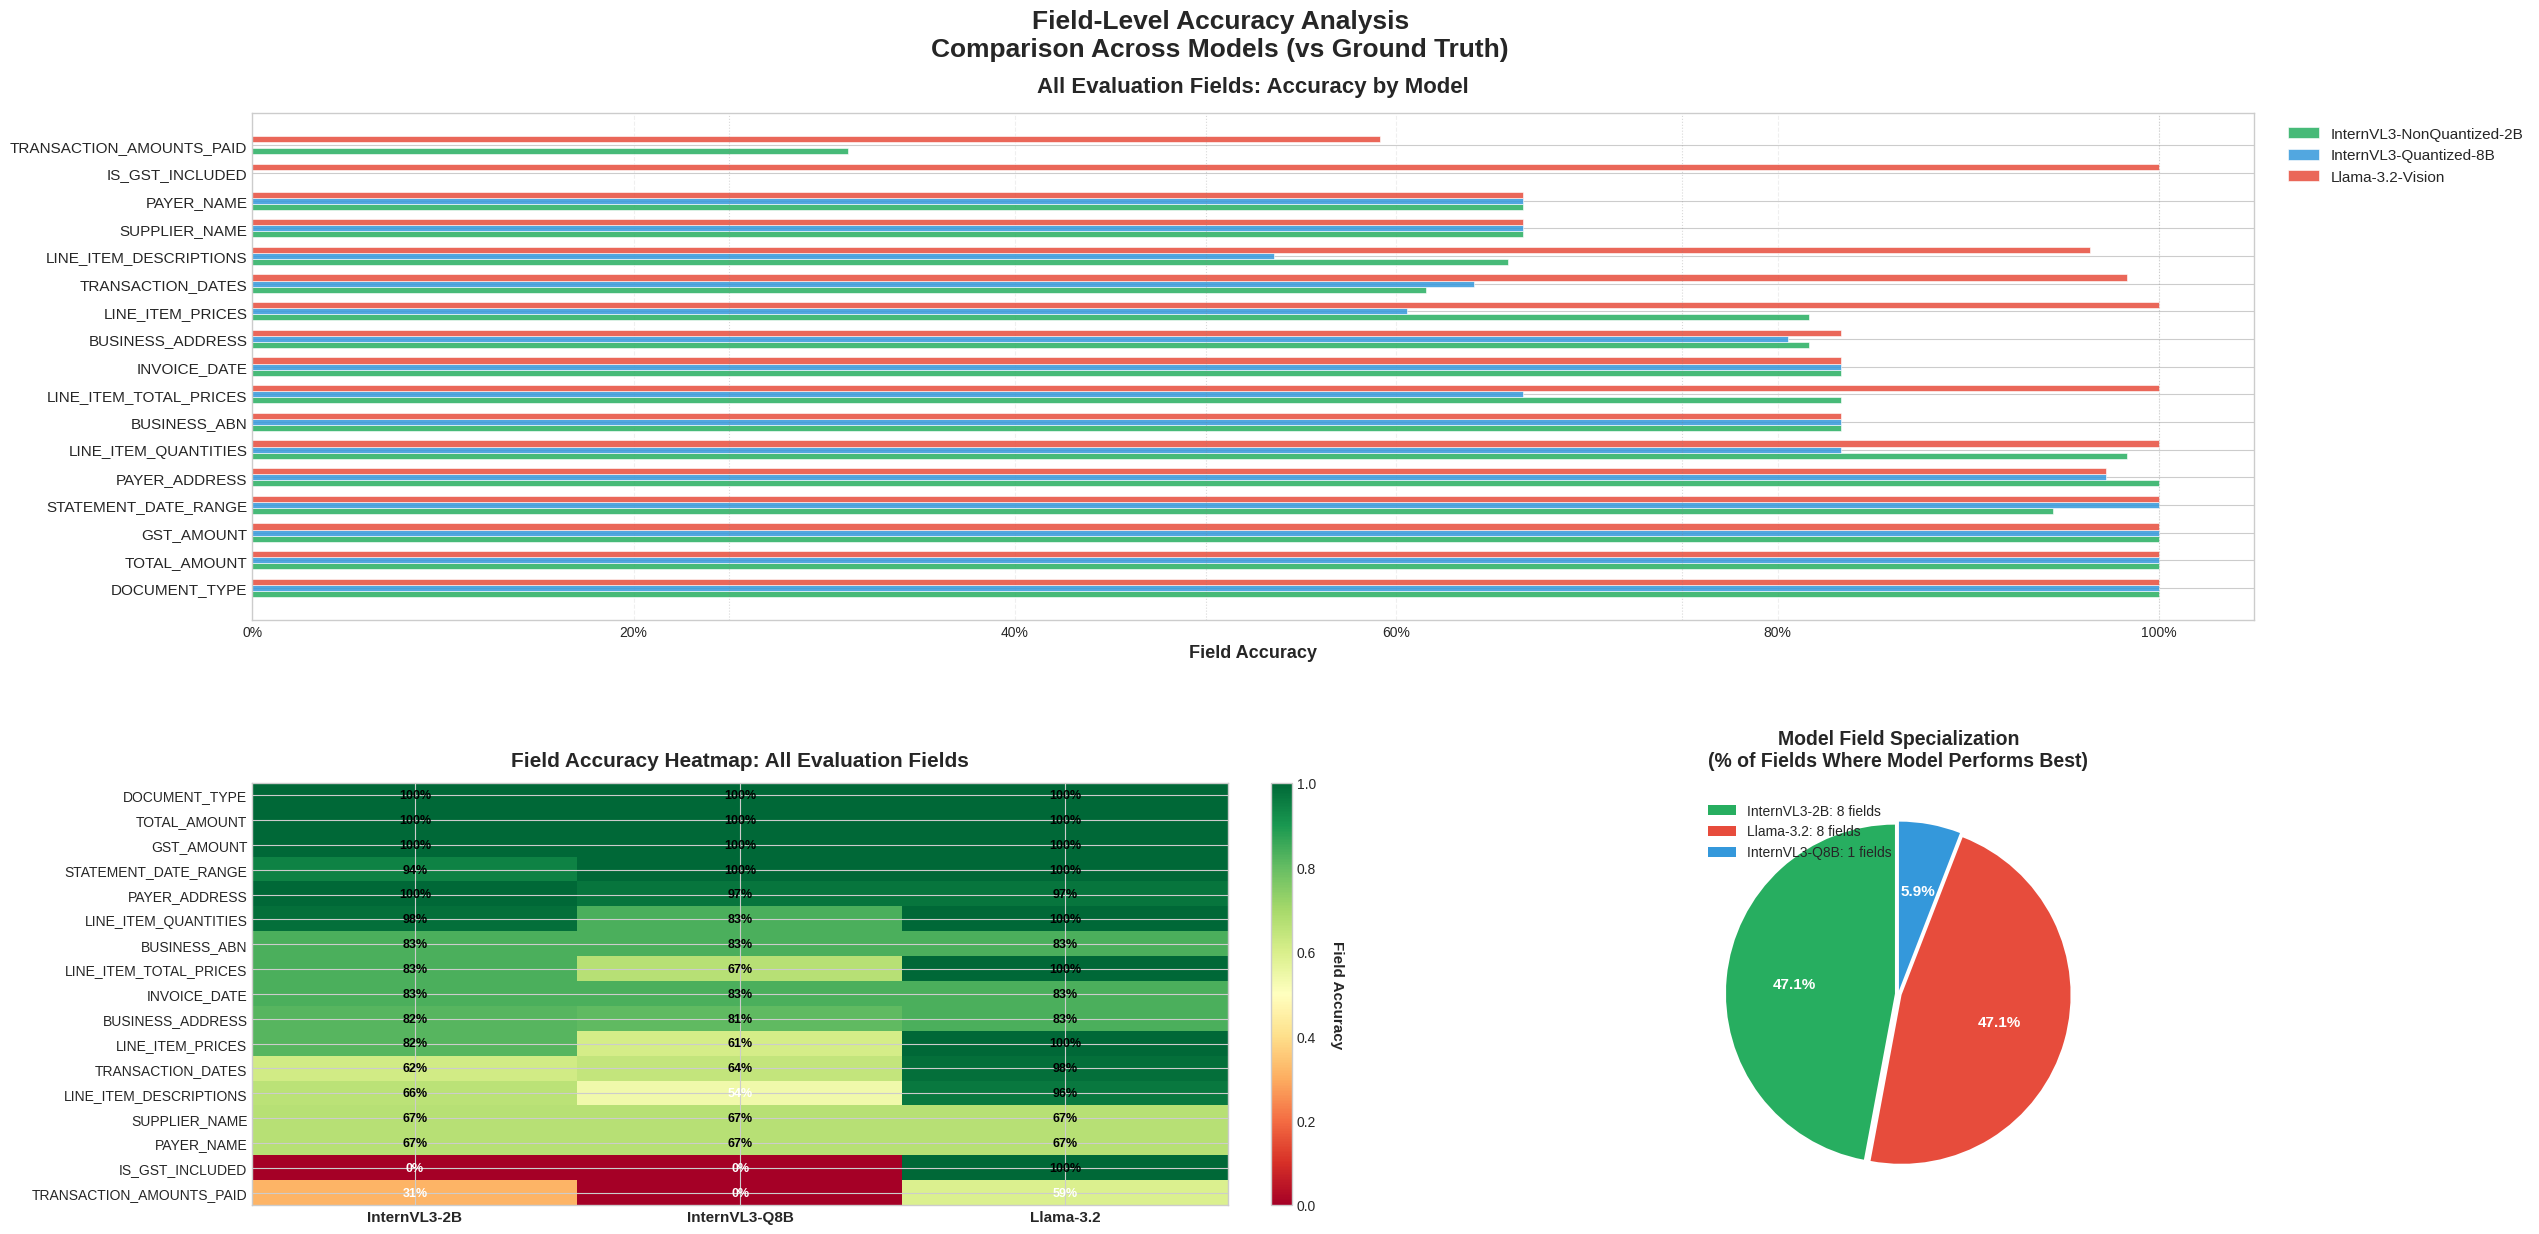

In [8]:
def create_field_level_visualizations(field_df: pd.DataFrame, field_performance: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive field-level performance visualizations.
    
    Args:
        field_df: Raw field-level accuracy data
        field_performance: Analyzed field performance comparison
        save_path: Optional path to save visualization
    """
    if field_df.empty or field_performance.empty:
        rprint("[red]❌ Cannot create field visualizations - no data available[/red]")
        return
    
    # Create figure with improved spacing
    fig = plt.figure(figsize=(22, 13))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1], width_ratios=[1.5, 1], 
                          hspace=0.35, wspace=0.25, top=0.90, bottom=0.06, left=0.06, right=0.97)
    
    # Color scheme matching main dashboard
    model_order = ['Llama-3.2-Vision', 'InternVL3-Quantized-8B', 'InternVL3-NonQuantized-2B']
    fixed_colors = {
        'Llama-3.2-Vision': '#E74C3C',
        'InternVL3-Quantized-8B': '#3498DB',
        'InternVL3-NonQuantized-2B': '#27AE60'
    }
    
    # Get available models
    available_models = field_df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = {model: fixed_colors[model] for model in models if model in fixed_colors}
    
    # 1. Field Accuracy Comparison (Horizontal Bar Chart) - IMPROVED
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get all evaluation fields by average accuracy
    all_eval_fields = field_performance
    model_cols = [col for col in all_eval_fields.columns if col in models]
    
    y_pos = np.arange(len(all_eval_fields))
    bar_height = 0.22
    
    # Create bars with better spacing
    for idx, model in enumerate(model_cols):
        offset = (idx - len(model_cols)/2 + 0.5) * bar_height
        bars = ax1.barh(y_pos + offset, all_eval_fields[model], bar_height, 
                label=model, color=model_colors.get(model, '#999999'), alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(all_eval_fields.index, fontsize=11)
    ax1.invert_yaxis()  # Match heatmap ordering (top-to-bottom)
    ax1.set_xlabel('Field Accuracy', fontsize=13, fontweight='bold')
    ax1.set_title('All Evaluation Fields: Accuracy by Model', fontsize=16, fontweight='bold', pad=15)
    
    # Improved legend placement - outside plot area to avoid occlusion
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11, framealpha=0.98, edgecolor='gray', shadow=True)
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax1.set_xlim(0, 1.05)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    
    # Add vertical reference lines
    for x in [0.25, 0.5, 0.75, 1.0]:
        ax1.axvline(x=x, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
    
    # 2. Field Accuracy Heatmap - IMPROVED
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Get all evaluation fields for heatmap (same as bar chart for consistency)
    heatmap_data = field_performance[model_cols]
    
    # Create heatmap with better colors
    im = ax2.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Improved tick labels
    ax2.set_xticks(np.arange(len(model_cols)))
    ax2.set_yticks(np.arange(len(heatmap_data)))
    
    # Better label formatting - shorten model names for display
    model_labels = []
    for model in model_cols:
        if model == 'Llama-3.2-Vision':
            model_labels.append('Llama-3.2')
        elif model == 'InternVL3-Quantized-8B':
            model_labels.append('InternVL3-Q8B')
        elif model == 'InternVL3-NonQuantized-2B':
            model_labels.append('InternVL3-2B')
        else:
            model_labels.append(model)
    
    ax2.set_xticklabels(model_labels, rotation=0, ha='center', fontsize=11, fontweight='bold')
    ax2.set_yticklabels(heatmap_data.index, fontsize=10)
    
    # Improved colorbar
    cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label('Field Accuracy', rotation=270, labelpad=20, fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add text annotations with better visibility
    for i in range(len(heatmap_data)):
        for j in range(len(model_cols)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                text_color = 'white' if value < 0.6 else 'black'
                ax2.text(j, i, f'{value:.0%}', ha='center', va='center', 
                        color=text_color, fontsize=9, fontweight='bold')
    
    ax2.set_title('Field Accuracy Heatmap: All Evaluation Fields', fontsize=15, fontweight='bold', pad=12)
    
    # 3. Model Specialization Pie Chart - IMPROVED
    ax3 = fig.add_subplot(gs[1, 1])
    
    specialization = field_performance['best_model'].value_counts()
    colors_list = [model_colors.get(model, '#999999') for model in specialization.index]
    
    # Improved pie chart with better labels
    wedges, texts, autotexts = ax3.pie(
        specialization.values,
        labels=None,  # We'll add custom labels
        autopct='%1.1f%%',
        colors=colors_list,
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        explode=[0.02] * len(specialization)  # Slight separation
    )
    
    # Make percentage text bold and white
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Add custom legend with shortened names
    legend_labels = []
    for model in specialization.index:
        count = specialization[model]
        pct = (count / len(field_performance)) * 100
        if model == 'Llama-3.2-Vision':
            legend_labels.append(f'Llama-3.2: {count} fields')
        elif model == 'InternVL3-Quantized-8B':
            legend_labels.append(f'InternVL3-Q8B: {count} fields')
        elif model == 'InternVL3-NonQuantized-2B':
            legend_labels.append(f'InternVL3-2B: {count} fields')
        else:
            legend_labels.append(f'{model}: {count} fields')
    
    ax3.legend(legend_labels, loc='upper left', fontsize=10, framealpha=0.95, 
               bbox_to_anchor=(0.02, 0.98), edgecolor='gray')
    
    ax3.set_title('Model Field Specialization\n(% of Fields Where Model Performs Best)', 
                 fontsize=14, fontweight='bold', pad=12)
    
    # Overall title - cleaned up
    fig.suptitle('Field-Level Accuracy Analysis\nComparison Across Models (vs Ground Truth)', 
                fontsize=19, fontweight='bold')
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight', facecolor='white')
        rprint(f"[green]✅ Field-level visualization saved to: {save_path}[/green]")
    
    plt.show()

# Create field-level visualizations
field_viz_timestamp = None
if not field_level_df.empty and 'field_performance' in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"output/visualizations/field_level_accuracy_{timestamp}.png")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_field_level_visualizations(field_level_df, field_performance, str(output_path))
    field_viz_timestamp = timestamp
else:
    rprint("[red]❌ Cannot create field visualizations - no field-level data available[/red]")

## 5. Detailed Performance Analysis

In [9]:
def analyze_model_strengths(df: pd.DataFrame):
    """
    Analyze and compare model strengths and weaknesses.
    """
    if df.empty:
        return
    
    rprint("\n[bold green]🎯 DETAILED PERFORMANCE ANALYSIS[/bold green]")
    
    # Document type winner analysis
    doc_performance = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    
    rprint("\n[bold blue]📊 Document Type Performance Leaders:[/bold blue]")
    for doc_type in doc_performance.index:
        best_model = doc_performance.loc[doc_type].idxmax()
        best_score = doc_performance.loc[doc_type].max()
        other_model = [m for m in doc_performance.columns if m != best_model][0]
        other_score = doc_performance.loc[doc_type, other_model]
        improvement = best_score - other_score
        
        rprint(f"  • **{doc_type}**: {best_model} leads with {best_score:.1f}% (+{improvement:.1f}% advantage)")
    
    # Speed analysis
    rprint("\n[bold blue]⚡ Processing Speed Analysis:[/bold blue]")
    speed_comparison = df.groupby('model')['processing_time'].agg(['mean', 'min', 'max', 'std'])
    for model in speed_comparison.index:
        stats = speed_comparison.loc[model]
        throughput = 60 / stats['mean']
        rprint(f"  • **{model}**: Avg {stats['mean']:.1f}s ({throughput:.1f} docs/min), Range {stats['min']:.1f}-{stats['max']:.1f}s")
    
    # Consistency analysis
    rprint("\n[bold blue]📈 Consistency Analysis (Lower std dev = more consistent):[/bold blue]")
    consistency = df.groupby('model')['overall_accuracy'].std()
    for model in consistency.index:
        rprint(f"  • **{model}**: ±{consistency[model]:.1f}% standard deviation")
    
    # Efficiency score (accuracy/time ratio)
    rprint("\n[bold blue]💡 Efficiency Score (Accuracy per Second):[/bold blue]")
    df['efficiency_score'] = df['overall_accuracy'] / df['processing_time']
    efficiency = df.groupby('model')['efficiency_score'].mean()
    for model in efficiency.index:
        rprint(f"  • **{model}**: {efficiency[model]:.2f} accuracy points per second")

# Run detailed analysis
if not combined_df.empty:
    analyze_model_strengths(combined_df)
else:
    rprint("[red]❌ Cannot run analysis - no data available[/red]")

🎯 DETAILED PERFORMANCE ANALYSIS

📊 Document Type Performance Leaders:

• **bank_statement**: Llama-3.2-Vision leads with 68.8% (+23.7% advantage)

• **invoice**: Llama-3.2-Vision leads with 97.4% (+13.4% advantage)

• **receipt**: Llama-3.2-Vision leads with 97.5% (+4.7% advantage)

⚡ Processing Speed Analysis:

• **InternVL3-NonQuantized-2B**: Avg 12.2s (4.9 docs/min), Range 6.0-43.0s

• **InternVL3-Quantized-8B**: Avg 39.9s (1.5 docs/min), Range 22.0-103.1s

• **Llama-3.2-Vision**: Avg 10.5s (5.7 docs/min), Range 6.8-27.8s

📈 Consistency Analysis (Lower std dev = more consistent):

• **InternVL3-NonQuantized-2B**: ±22.5% standard deviation

• **InternVL3-Quantized-8B**: ±16.4% standard deviation

• **Llama-3.2-Vision**: ±16.3% standard deviation

💡 Efficiency Score (Accuracy per Second):

• **InternVL3-NonQuantized-2B**: 9.14 accuracy points per second

• **InternVL3-Quantized-8B**: 2.42 accuracy points per second

• **Llama-3.2-Vision**: 10.48 accuracy points per second

## 6. Business Recommendations

In [10]:
def generate_business_recommendations(df: pd.DataFrame, field_performance: pd.DataFrame = None):
    """
    Generate executive business recommendations based on CSV data analysis only.
    """
    if df.empty:
        return
    
    rprint("\n[bold green]💼 EXECUTIVE BUSINESS RECOMMENDATIONS[/bold green]")
    
    # Overall performance leader
    overall_leader = df.groupby('model')['overall_accuracy'].mean().idxmax()
    speed_leader = df.groupby('model')['processing_time'].mean().idxmin()
    
    # Calculate key metrics
    model_stats = df.groupby('model').agg({
        'overall_accuracy': 'mean',
        'processing_time': 'mean'
    })
    
    rprint("\n[bold blue]🎯 PRIMARY RECOMMENDATION:[/bold blue]")
    
    if overall_leader == speed_leader:
        rprint(f"  • **Deploy {overall_leader}** - Clear winner on both accuracy and speed")
    else:
        accuracy_leader_score = model_stats.loc[overall_leader, 'overall_accuracy']
        speed_leader_score = model_stats.loc[speed_leader, 'processing_time']
        
        rprint(f"  • **For Accuracy-Critical Applications**: Deploy {overall_leader} ({accuracy_leader_score:.1f}% avg accuracy)")
        rprint(f"  • **For High-Volume Processing**: Deploy {speed_leader} ({speed_leader_score:.1f}s avg processing)")
    
    rprint("\n[bold blue]📋 USE CASE SPECIFIC RECOMMENDATIONS:[/bold blue]")
    
    # Document-specific recommendations
    doc_performance = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    
    for doc_type in doc_performance.index:
        best_model = doc_performance.loc[doc_type].idxmax()
        best_score = doc_performance.loc[doc_type].max()
        rprint(f"  • **{doc_type.title()} Processing**: Use {best_model} ({best_score:.1f}% accuracy)")
    
    # Field-specific recommendations
    if field_performance is not None and not field_performance.empty:
        rprint("\n[bold blue]🔍 FIELD-SPECIFIC RECOMMENDATIONS:[/bold blue]")
        
        # Identify fields with significant performance differences between models
        model_cols = [col for col in field_performance.columns if col not in ['avg_accuracy', 'variance', 'best_model', 'best_score', 'max_diff']]
        
        if len(model_cols) >= 2:
            # Calculate performance spread for each field
            field_performance['max_diff'] = field_performance[model_cols].max(axis=1) - field_performance[model_cols].min(axis=1)
            
            # Get fields with significant differences (>20% spread)
            significant_diff_fields = field_performance[field_performance['max_diff'] > 0.2].nlargest(5, 'max_diff')
            
            if not significant_diff_fields.empty:
                rprint("  **Fields with Significant Model Performance Differences:**")
                for field_name, row in significant_diff_fields.iterrows():
                    best_model = row['best_model']
                    best_score = row['best_score']
                    worst_score = row[model_cols].min()
                    advantage = best_score - worst_score
                    rprint(f"    • {field_name}: Use **{best_model}** ({best_score:.0%} vs {worst_score:.0%}, +{advantage:.0%} advantage)")
        
        # Identify consistently problematic fields
        problematic_fields = field_performance[field_performance['avg_accuracy'] < 0.5]
        if not problematic_fields.empty:
            rprint("\n  **⚠️ Fields Requiring Attention (Low Accuracy):**")
            for field_name, row in problematic_fields.head(5).iterrows():
                avg_acc = row['avg_accuracy']
                rprint(f"    • {field_name}: {avg_acc:.0%} average accuracy - Consider prompt optimization")
    
    rprint("\n[bold blue]📊 PERFORMANCE EFFICIENCY (CSV Data Only):[/bold blue]")
    
    # Calculate pure performance efficiency metrics from CSV data only
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        avg_accuracy = model_data['overall_accuracy'].mean()
        avg_time = model_data['processing_time'].mean()
        throughput = 60 / avg_time
        
        # Pure efficiency score based only on CSV performance data
        efficiency_score = avg_accuracy * throughput
        rprint(f"  • **{model}**: Efficiency score {efficiency_score:.1f} (accuracy × throughput)")
    
    rprint("\n[bold blue]⚡ PERFORMANCE COMPARISON SUMMARY:[/bold blue]")
    
    # Generate data-driven insights based only on CSV metrics
    accuracy_winner = df.groupby('model')['overall_accuracy'].mean().idxmax()
    speed_winner = df.groupby('model')['processing_time'].mean().idxmin()
    consistency_winner = df.groupby('model')['overall_accuracy'].std().idxmin()
    
    rprint(f"  • **Highest Average Accuracy**: {accuracy_winner}")
    rprint(f"  • **Fastest Processing**: {speed_winner}")  
    rprint(f"  • **Most Consistent Results**: {consistency_winner}")

# Generate recommendations with field-level insights
if not combined_df.empty:
    field_perf = field_performance if 'field_performance' in locals() and not field_performance.empty else None
    generate_business_recommendations(combined_df, field_perf)
else:
    rprint("[red]❌ Cannot generate recommendations - no data available[/red]")

💼 EXECUTIVE BUSINESS RECOMMENDATIONS

🎯 PRIMARY RECOMMENDATION:

• **Deploy Llama-3.2-Vision** - Clear winner on both accuracy and speed

📋 USE CASE SPECIFIC RECOMMENDATIONS:

• **Bank_Statement Processing**: Use Llama-3.2-Vision (68.8% accuracy)

• **Invoice Processing**: Use Llama-3.2-Vision (97.4% accuracy)

• **Receipt Processing**: Use Llama-3.2-Vision (97.5% accuracy)

🔍 FIELD-SPECIFIC RECOMMENDATIONS:

**Fields with Significant Model Performance Differences:**

• IS_GST_INCLUDED: Use **Llama-3.2-Vision** (100% vs 0%, +100% advantage)

• TRANSACTION_AMOUNTS_PAID: Use **Llama-3.2-Vision** (59% vs 0%, +59% advantage)

• LINE_ITEM_DESCRIPTIONS: Use **Llama-3.2-Vision** (96% vs 54%, +43% advantage)

• LINE_ITEM_PRICES: Use **Llama-3.2-Vision** (100% vs 61%, +39% advantage)

• TRANSACTION_DATES: Use **Llama-3.2-Vision** (98% vs 62%, +37% advantage)

**⚠️ Fields Requiring Attention (Low Accuracy):**

• IS_GST_INCLUDED: 33% average accuracy - Consider prompt optimization

• TRANSACTION_AMOUNTS_PAID: 30% average accuracy - Consider prompt optimization

📊 PERFORMANCE EFFICIENCY (CSV Data Only):

• **Llama-3.2-Vision**: Efficiency score 501.7 (accuracy × throughput)

• **InternVL3-Quantized-8B**: Efficiency score 112.6 (accuracy × throughput)

• **InternVL3-NonQuantized-2B**: Efficiency score 363.9 (accuracy × throughput)

⚡ PERFORMANCE COMPARISON SUMMARY:

• **Highest Average Accuracy**: Llama-3.2-Vision

• **Fastest Processing**: Llama-3.2-Vision

• **Most Consistent Results**: Llama-3.2-Vision

In [11]:
def export_executive_report(df: pd.DataFrame, output_dir: str = "output/reports", visualization_timestamp: str = None):
    """
    Export a comprehensive executive report in multiple formats.
    """
    if df.empty:
        rprint("[red]❌ Cannot export report - no data available[/red]")
        return
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Export detailed CSV comparison
    comparison_file = output_path / f"executive_model_comparison_{timestamp}.csv"
    df.to_csv(comparison_file, index=False)
    
    # Export summary statistics
    summary_file = output_path / f"executive_summary_{timestamp}.csv"
    summary_stats = generate_executive_summary(df)
    summary_stats.to_csv(summary_file, index=False)
    
    rprint("\n[green]✅ Executive reports exported:[/green]")
    rprint(f"  • Detailed comparison: {comparison_file}")
    rprint(f"  • Executive summary: {summary_file}")
    
    # Generate markdown report with visualization
    markdown_file = output_path / f"executive_report_{timestamp}.md"
    with open(markdown_file, 'w') as f:
        f.write("# Executive Model Comparison Report\n\n")
        f.write(f"**Generated**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # Include visualization if available
        if visualization_timestamp:
            viz_path = f"../visualizations/executive_comparison_{visualization_timestamp}.png"
            f.write("## Performance Dashboard\n\n")
            f.write(f"![Executive Performance Comparison]({viz_path})\n\n")
        
        f.write("## Executive Summary\n\n")
        
        # Model comparison summary
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            avg_acc = model_data['overall_accuracy'].mean()
            avg_time = model_data['processing_time'].mean()
            throughput = 60 / avg_time
            
            f.write(f"### {model}\n")
            f.write(f"- **Average Accuracy**: {avg_acc:.1f}%\n")
            f.write(f"- **Average Processing Time**: {avg_time:.1f} seconds\n")
            f.write(f"- **Throughput**: {throughput:.1f} documents per minute\n")
            f.write(f"- **Documents Processed**: {len(model_data)}\n\n")
        
        f.write("## Document Type Performance\n\n")
        doc_perf = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
        f.write(doc_perf.to_markdown())
        f.write("\n\n## Key Findings\n\n")
        
        # Add key findings based on data
        accuracy_leader = df.groupby('model')['overall_accuracy'].mean().idxmax()
        speed_leader = df.groupby('model')['processing_time'].mean().idxmin()
        
        f.write(f"- **Accuracy Leader**: {accuracy_leader}\n")
        f.write(f"- **Speed Leader**: {speed_leader}\n")
        f.write(f"- **Best for Invoices**: {df[df['document_type']=='invoice'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
        f.write(f"- **Best for Receipts**: {df[df['document_type']=='receipt'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
        f.write(f"- **Best for Bank Statements**: {df[df['document_type']=='bank_statement'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
        
        f.write("\n\n## Recommendations\n\n")
        f.write("Detailed recommendations and analysis available in the full comparison notebook.\n")
    
    rprint(f"  • Markdown report: {markdown_file}")

In [12]:
# Export reports with visualization reference
if not combined_df.empty:
    # Use the dashboard timestamp from earlier
    export_executive_report(combined_df, visualization_timestamp=dashboard_timestamp)
    
    rprint("\n[bold green]🎉 Executive Analysis Complete![/bold green]")
    rprint("[cyan]📊 Dashboard and reports are ready for executive presentation[/cyan]")
else:
    rprint("[red]❌ Cannot export reports - no data available[/red]")
    rprint("\n[yellow]💡 To use this notebook:[/yellow]")
    rprint("  1. Run llama_document_aware_batch.ipynb to generate Llama results")
    rprint("  2. Run internvl3_document_aware_batch.ipynb to generate InternVL3 results")
    rprint("  3. Re-run this notebook to generate the executive comparison")

✅ Executive reports exported:

• Detailed comparison: output/reports/executive_model_comparison_20251019_023604.csv

• Executive summary: output/reports/executive_summary_20251019_023604.csv

• Markdown report: output/reports/executive_report_20251019_023604.md

🎉 Executive Analysis Complete!

📊 Dashboard and reports are ready for executive presentation